# Exploración de datos con pandas: Adult Income Dataset

En este notebook vamos a:

1. Cargar un dataset real directamente desde la web.
2. Entender su estructura (filas, columnas, tipos de dato).
3. Explorar problemas de calidad de datos (valores faltantes, categorías "raras", outliers).
4. Identificar posibles fuentes de sesgo y variables sensibles.

Dataset: *Adult Income* (censo de EE. UU.). La tarea típica es predecir si el ingreso de una persona es > 50K USD/año.

In [1]:
import pandas as pd

pd.set_option("display.max_columns", 50)

In [2]:
url = "https://raw.githubusercontent.com/DataResponsibly/Datasets/master/AdultIncomeData/adult.csv"
df = pd.read_csv(url)

df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
cat_cols = ["workclass", "education", "marital-status", "occupation",
            "relationship", "race", "sex", "native-country", "income"]

for col in cat_cols:
    print(f"\n==== {col} ====")
    print(df[col].value_counts(dropna=False).head(15))


==== workclass ====
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

==== education ====
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Name: count, dtype: int64

==== marital-status ====
marital-status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64

==== occupation ====
occupation
Prof-

In [4]:
df.workclass.unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [5]:
# Conteo de "?" por columna
(df == " ?").sum().sort_values(ascending=False)

occupation        1843
workclass         1836
native-country     583
fnlwgt               0
education            0
education-num        0
age                  0
marital-status       0
relationship         0
sex                  0
race                 0
capital-gain         0
capital-loss         0
hours-per-week       0
income               0
dtype: int64

In [6]:
# Reemplazar "?" por NaN
import numpy as np

df_clean = df.replace(" ?", np.nan)

# Porcentaje de valores faltantes por columna
missing_pct = df_clean.isna().mean().sort_values(ascending=False) * 100
missing_pct


occupation        5.660146
workclass         5.638647
native-country    1.790486
fnlwgt            0.000000
education         0.000000
education-num     0.000000
age               0.000000
marital-status    0.000000
relationship      0.000000
sex               0.000000
race              0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
income            0.000000
dtype: float64

### Preguntas

1. ¿En qué variables hay más valores faltantes (NaN / “?”)?
2. ¿Qué tipo de información falta (ocupación, país, etc.)?  
3. ¿Cómo podría afectar esto a un modelo de predicción de ingreso?
4. Si eliminara todas las filas con datos faltantes, ¿a quién estaría dejando por fuera?


In [7]:
# Versión "agresiva": eliminar filas con algún NaN
df_dropna = df_clean.dropna()

df.shape, df_dropna.shape

((32561, 15), (30162, 15))

In [8]:
# Comparar distribución de algunas variables antes y después
cols_check = ["sex", "race", "native-country", "occupation"]

for col in cols_check:
    print(f"\n=== {col} - original ===")
    print(df_clean[col].value_counts(normalize=True).head(10))

    print(f"\n=== {col} - dropna ===")
    print(df_dropna[col].value_counts(normalize=True).head(10))



=== sex - original ===
sex
Male      0.669205
Female    0.330795
Name: proportion, dtype: float64

=== sex - dropna ===
sex
Male      0.675685
Female    0.324315
Name: proportion, dtype: float64

=== race - original ===
race
White                 0.854274
Black                 0.095943
Asian-Pac-Islander    0.031909
Amer-Indian-Eskimo    0.009551
Other                 0.008323
Name: proportion, dtype: float64

=== race - dropna ===
race
White                 0.859790
Black                 0.093396
Asian-Pac-Islander    0.029673
Amer-Indian-Eskimo    0.009482
Other                 0.007659
Name: proportion, dtype: float64

=== native-country - original ===
native-country
United-States    0.912190
Mexico           0.020108
Philippines      0.006192
Germany          0.004284
Canada           0.003784
Puerto-Rico      0.003565
El-Salvador      0.003315
India            0.003127
Cuba             0.002971
England          0.002814
Name: proportion, dtype: float64

=== native-country - dropn

### Sesgos introducidos por decisiones de limpieza

- Al eliminar todas las filas con valores faltantes:
  - ¿Cambió la proporción de mujeres vs. hombres?
  - ¿Cambió la proporción de ciertas razas o países de origen?
  - ¿Qué grupos parecen perder más registros?

Piense como consultor/a:

- ¿Cómo explicaría a un cliente (banco, gobierno) que una decisión de limpieza puede **empeorar** la equidad del sistema?
- ¿Qué alternativas podría explorar en lugar de simplemente borrar filas?


In [9]:
# Ejemplo: distribución de ingreso por sexo
pd.crosstab(df_dropna["sex"], df_dropna["income"], normalize="index") * 100


income,<=50K,>50K
sex,,
Female,88.632182,11.367818
Male,68.616290,31.383710


In [10]:
# Distribución de ingreso por raza
pd.crosstab(df_dropna["race"], df_dropna["income"], normalize="index") * 100


income,<=50K,>50K
race,,
Amer-Indian-Eskimo,88.111888,11.888112
Asian-Pac-Islander,72.290503,27.709497
Black,87.007455,12.992545
Other,90.909091,9.090909
White,73.628196,26.371804


## Visualización

In [11]:
import matplotlib.pyplot as plt

In [13]:
# Reemplazar "?" por NaN para facilitar análisis
df = df.replace(" ?", np.nan)

# Asegurar que la columna de ingreso no tenga espacios
df["income"] = df["income"].str.strip()

# Crear una variable binaria de ingresos altos
df["high_income"] = (df["income"] == ">50K").astype(int)

df[["income", "high_income"]].head()

,income,high_income
0,<=50K,0
1,<=50K,0
2,<=50K,0
3,<=50K,0
4,<=50K,0


## 1. Distribuciones: ¿cómo luce nuestra población?

Primero vamos a mirar cómo se distribuyen algunas variables numéricas:

- `age` (edad)
- `hours-per-week` (horas trabajadas por semana)

Usaremos histogramas para:

- Ver si las distribuciones son simétricas o sesgadas.
- Identificar valores extremos (outliers).
- Empezar a pensar qué resumen (media, mediana) tiene más sentido.


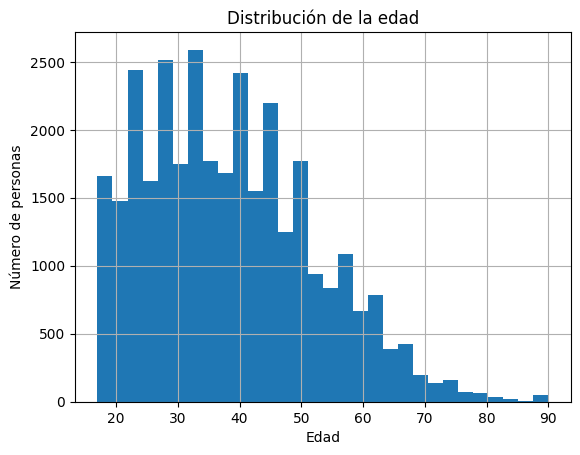

In [14]:
# Histograma de edades
df["age"].hist(bins=30)
plt.xlabel("Edad")
plt.ylabel("Número de personas")
plt.title("Distribución de la edad")
plt.show()


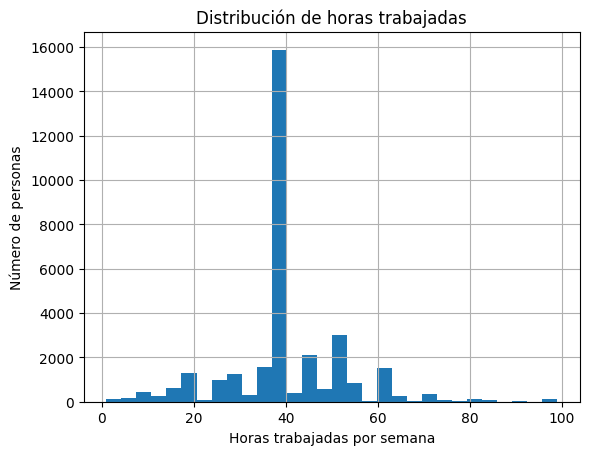

In [15]:
# Histograma de horas trabajadas por semana
df["hours-per-week"].hist(bins=30)
plt.xlabel("Horas trabajadas por semana")
plt.ylabel("Número de personas")
plt.title("Distribución de horas trabajadas")
plt.show()


### Preguntas de interpretación

1. ¿La distribución de edades es simétrica o está sesgada hacia algún lado?
2. ¿Hay valores extremos (por ejemplo, muchas personas trabajando muy pocas o muchas horas)?
3. Si tuvieras que resumir cada variable en **un solo número**, ¿usaría media, mediana o ambas? ¿Por qué?



In [16]:
summary = pd.DataFrame({
    "media": df[["age", "hours-per-week"]].mean(),
    "mediana": df[["age", "hours-per-week"]].median()
})
summary


,media,mediana
age,38.581647,37.0
hours-per-week,40.437456,40.0


**Ejercicio:**

Redacte una frase para cada variable que combine número + interpretación, por ejemplo:

- “La mediana de edad en el dataset es de **X años**, lo que indica que la mitad de la población tiene menos de esa edad.”
- “La media de horas trabajadas por semana es de **Y horas**, pero el histograma muestra que hay un grupo no despreciable trabajando muchas más horas que el promedio.”

La idea es practicar cómo pasamos de números a frases que cualquier persona pueda entender.


## 2. Comparando grupos: ¿quién tiene más probabilidad de tener ingresos altos?

Vamos a calcular y visualizar la **proporción de personas con ingresos >50K** según:

- Sexo (`sex`)
- Raza (`race`)
- Nivel educativo (`education`)

Esto nos sirve para:

- Ver brechas entre grupos.
- Empezar a imaginar qué pasaría si entrenáramos un modelo sin cuidar estos temas.

In [17]:
def tasa_high_income_por_grupo(df, col_grupo):
    """
    Calcula la proporción de personas con high_income = 1 por categoría de col_grupo.
    Devuelve un DataFrame con columnas [col_grupo, "tasa_high_income"].
    """
    tabla = df.groupby(col_grupo)["high_income"].mean().reset_index()
    tabla = tabla.sort_values("high_income", ascending=False)
    tabla.rename(columns={"high_income": "tasa_high_income"}, inplace=True)
    return tabla

tasa_sex = tasa_high_income_por_grupo(df, "sex")
tasa_race = tasa_high_income_por_grupo(df, "race")
tasa_edu = tasa_high_income_por_grupo(df, "education")

tasa_sex


,sex,tasa_high_income
1,Male,0.305737
0,Female,0.109461


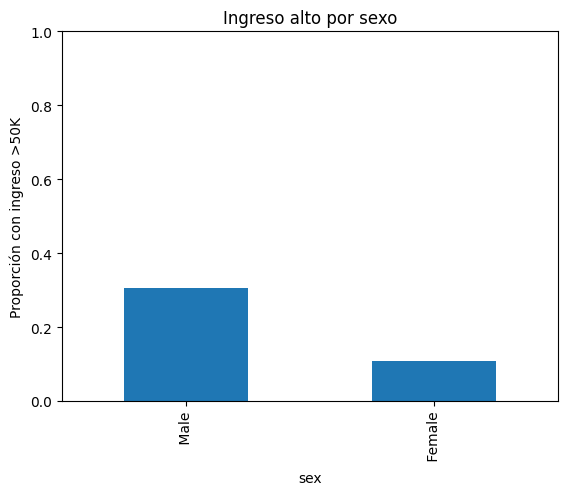

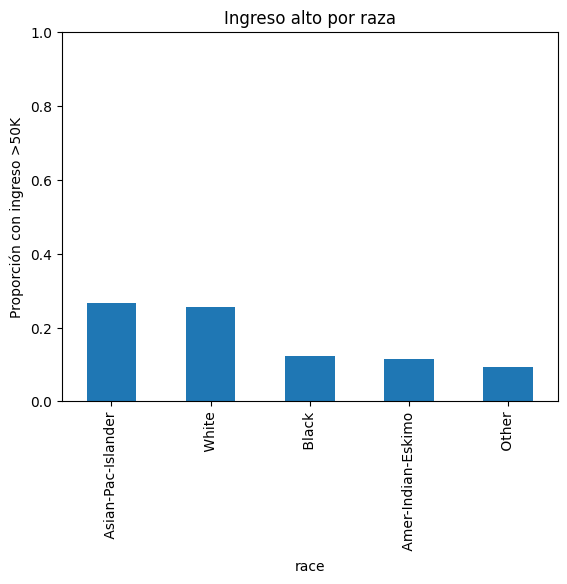

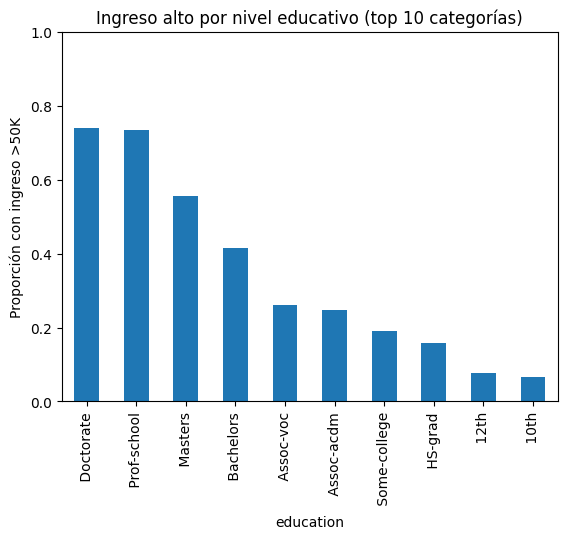

In [18]:
# Sexo
tasa_sex.plot(kind="bar", x="sex", y="tasa_high_income", legend=False)
plt.ylabel("Proporción con ingreso >50K")
plt.title("Ingreso alto por sexo")
plt.ylim(0, 1)
plt.show()

# Raza
tasa_race.plot(kind="bar", x="race", y="tasa_high_income", legend=False)
plt.ylabel("Proporción con ingreso >50K")
plt.title("Ingreso alto por raza")
plt.ylim(0, 1)
plt.show()

# Educación (puede ser muchas categorías; muestra las principales)
tasa_edu.head(10).plot(kind="bar", x="education", y="tasa_high_income", legend=False)
plt.ylabel("Proporción con ingreso >50K")
plt.title("Ingreso alto por nivel educativo (top 10 categorías)")
plt.ylim(0, 1)
plt.show()


In [19]:
# Distribución conjunta de income por sexo
crosstab_sex = pd.crosstab(df["sex"], df["income"], normalize="index") * 100
crosstab_sex


income,<=50K,>50K
sex,,
Female,89.053941,10.946059
Male,69.426342,30.573658


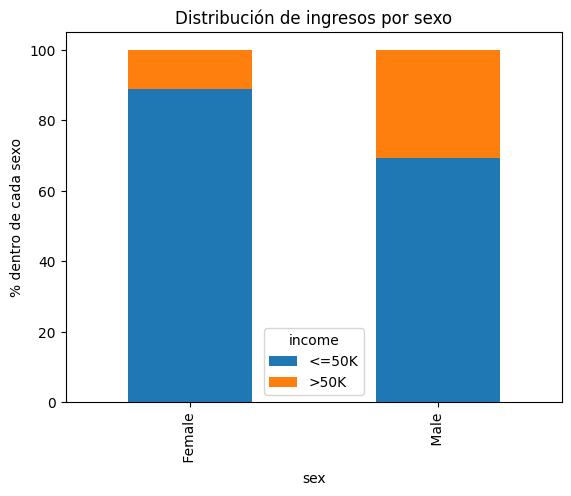

In [20]:
crosstab_sex.plot(kind="bar", stacked=True)
plt.ylabel("% dentro de cada sexo")
plt.title("Distribución de ingresos por sexo")
plt.show()


## Otros gráficos

In [ ]:
# Distribución de income (<=50K vs >50K)
income_counts = df["income"].value_counts()

plt.figure()
plt.pie(
    income_counts,
    labels=income_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Distribución de niveles de ingreso")
plt.show()


## Scatterplot con tres dimensiones

Un diagrama de dispersión (scatterplot) muestra la relación entre dos variables numéricas.
Podemos añadir una tercera dimensión usando:

- Color (para distinguir grupos).
- Tamaño de los puntos (para indicar intensidad o magnitud).

Ejemplo: edad (x), horas trabajadas (y), color según si la persona tiene ingreso >50K.


In [ ]:
import seaborn as sns

In [ ]:
# Muestra aleatoria para que el gráfico no quede tan saturado
df_sample = df.sample(n=3000, random_state=42)

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df_sample,
    x="age",
    y="hours-per-week",
    hue="sex",
    alpha=0.6
)
plt.title("Edad vs horas trabajadas por semana, coloreado por sexo")
plt.xlabel("Edad")
plt.ylabel("Horas trabajadas por semana")
plt.legend(title="Sexo")
plt.show()


In [ ]:
df_sample = df.sample(n=3000, random_state=42).copy()
df_sample["capital-gain"] = df_sample["capital-gain"].fillna(0)

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df_sample,
    x="age",
    y="hours-per-week",
    hue="sex",
    size="capital-gain",
    alpha=0.6,
    sizes=(10, 80)  # rango de tamaños
)
plt.title("Edad vs horas trabajadas, color por sexo, tamaño por capital-gain")
plt.xlabel("Edad")
plt.ylabel("Horas trabajadas por semana")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


### ¿Qué podemos leer de estos scatterplots?

- ¿En qué zonas del gráfico se concentran las personas con ingresos altos (>50K)?
- ¿Hay diferencias claras por sexo en la relación edad–horas trabajadas?
- Cuando añadimos el tamaño según `capital-gain`, ¿aparecen patrones nuevos o solo ruido visual?
- Si entrenáramos un modelo de IA usando estas variables, ¿qué tipos de decisiones podría aprender?
- ¿Hay riesgos de que el modelo favorezca ciertos rangos de edad, sexo o patrones de trabajo?
